<a href="https://colab.research.google.com/github/suann124/AIinTeaching/blob/main/lectures/L4_Firstorder_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First-Order Systems

## What are first-order systems?

Scalar first-order linear systems are the simplest type of dynamical systems that can be described by a first-order ordinary differential equation

$$
\frac{dx(t)}{dt} = A x(t) + B u(t)
$$

where $A \in \mathbb{R}$ and $B \in \mathbb{R}$. Here, $x(t)$ is the state of the system at time $t$ and $u(t)$ is the input to the system at time $t$.
Let's consider that the system is initialized at the initial condition $x_{0} \in \mathbb{R}$.


> Wonder why: What makes a differential equation an __ordinary__ differential equation?

## Example: Adaptive Cruise Control

In adaptive cruise control, we want to regulate the vehicle speed by applying engine torque. To keep things simple, we will ignore road slope and other disturbances for now, and focus only on how torque changes the speed.

$\color{red}{TODO: Some figure of the car.}$

This gives us a very clean first-order system: the car speeds up when torque is applied, and it naturally slows down due to drag when no torque is applied.


From Newton's law, the vehicle dynamics can be written as

$$
m \dot v(t) = k_u u(t) - b v(t),
$$

where
* $v(t)$ is the vehicle speed,
* $u(t)$ is the engine torque input,
* $m$ is the vehicle mass,
* $k_u$ converts torque to driving force,
* $b$ is the drag coefficient.

Dividing through by $m$ gives

$$
\dot v(t) = -\frac{b}{m} v(t) + \frac{k_u}{m} u(t).
$$

By defining the state as $x(t) = v(t)$, the dynamics can be written in state-space form as

$$
\dot x(t) = A x(t) + B u(t)
$$

with parameters

$$
A = -\frac{b}{m} \text{ and } B = \frac{k_u}{m}.
$$

## Code Example

Every physical model begins with describing the system.

* The drag term $b v$ resists motion.
* The input $k_u u$ turns torque into forward force.
* Newton's law says $m \dot{v} = k_u u - b v$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Vehicle parameters
m   = 1500.0   # vehicle mass [kg]
b   = 300.0    # drag coefficient [N*s/m]
k_u = 50.0     # drive-force per torque unit [N per N·m]

# Simulation setup
t_end = 25.0   # total simulation time [s]
dt    = 0.01   # time step [s]
t     = np.arange(0.0, t_end + dt, dt)

A step input means we instantaneously increase torque and hold it there.
Imagine pressing the accelerator pedal quickly and keeping it steady.

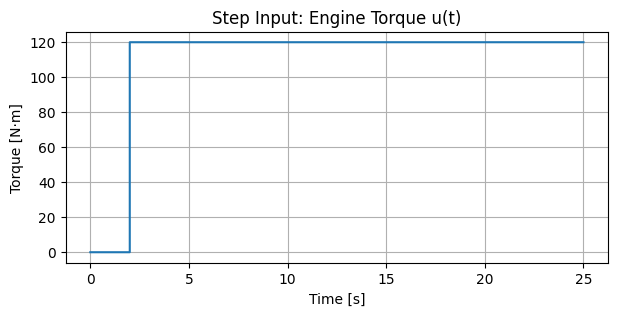

In [ ]:
# Define a step torque input

def u_torque(t_scalar: float) -> float:
    """
    A 'step input' represents a sudden, constant increase in torque.
    At t = 2 s, we apply 120 N·m of torque and keep it constant.
    """
    return 120.0 if t_scalar >= 2.0 else 0.0

# Plot the input profile
u = np.array([u_torque(ti) for ti in t])

plt.figure(figsize=(7,3))
plt.step(t, u, where="post")
plt.title("Step Input: Engine Torque u(t)")
plt.xlabel("Time [s]")
plt.ylabel("Torque [N·m]")
plt.grid(True)
plt.show()

Next we define the dynamics of the system as a function, using the equations above:

$$
\dot v = -\frac{b}{m} v + \frac{k_u}{m} u
$$

With a continuous-time simulation solver using scipy.integrate.solve_ivp:

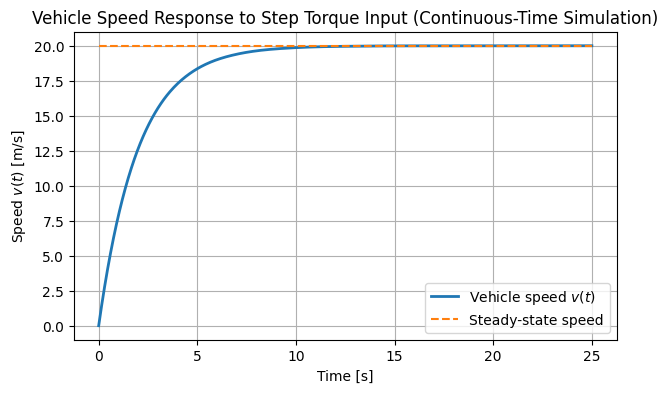

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Parameters ---
m = 1000.0     # mass [kg]
b = 500.0       # damping coefficient [N·s/m]
k_u = 10000.0    # input gain [N/(unit input)]
u_m = 1.0      # step torque input magnitude
t_end = 25.0   # simulation duration [s]

# --- Step input ---
def u_torque(t):
    return u_m if t >= 0 else 0.0

# --- Continuous-time vehicle dynamics ---
def vehicle_dynamics(t, v, m, b, k_u):
    """
    dv/dt = (-b/m)*v + (k_u/m)*u(t)
    """
    u = u_torque(t)
    return (-b/m) * v + (k_u/m) * u

# --- Simulate using solve_ivp ---
t_span = (0, t_end)
t_eval = np.linspace(0, t_end, 500)
v0 = [0.0]

sol = solve_ivp(vehicle_dynamics, t_span, v0, args=(m, b, k_u), t_eval=t_eval)

# --- Extract results ---
t = sol.t
v = sol.y[0]
u = np.array([u_torque(ti) for ti in t])

# --- Plot results ---
plt.figure(figsize=(7,4))
plt.plot(t, v, linewidth=2, label="Vehicle speed $v(t)$")
plt.plot(t, u * (k_u/b), "--", label="Steady-state speed")
plt.title("Vehicle Speed Response to Step Torque Input (Continuous-Time Simulation)")
plt.xlabel("Time [s]")
plt.ylabel("Speed $v(t)$ [m/s]")
plt.grid(True)
plt.legend()
plt.show()

At $t = 2 $seconds, the torque jumps from 0 to 120 N·m.

$\color{red}{TODO: Increase the gain. Goes to 20 quicker.}$
$\color{blue}{Done}$

The car's speed rises exponentially toward a steady value determined by $k_u u / b$.

This is exactly what a first-order system looks like: one state, one time constant.

> Try for yourself:
>
> * Increasing $m$ makes the car respond more slowly (heavier car → slower response).
> * Increasing $b$ makes it harder to reach high speeds (more drag).
> * Increasing $k_u$ increases acceleration (stronger drive).

## Adding Disturbances (Slope/Drag)

In reality, a car doesn't just respond to torque. Road slope and other forces (like wind drag or rolling resistance) act as disturbances. These affect the speed even if the driver (or controller) applies the same torque.

To capture this, we add two disturbance terms:
* Road inclination $\theta(t)$, which creates an uphill or downhill force,
* External disturbance $w(t)$, which represents extra forces such as wind gusts.

### Vehicle Dynamics

The full longitudinal dynamics are

$$
m \dot v(t) = k_u u(t) - b v(t) - m g \theta(t) + w(t),
$$

where
* $- m g \theta(t)$ models the component of gravity on a slope (using $\sin \theta \approx \theta$ for small angles), and
* $w(t)$ is a lumped disturbance force.

Dividing through by $m$ gives

$$
\dot v(t) = -\frac{b}{m} v(t) + \frac{k_u}{m} u(t) - g \theta(t) + \frac{1}{m} w(t).
$$

## Code Example

We'll add gravity $g$ for the slope term and use a longer simulation so we can see the effects clearly.

In [ ]:
m   = 1500.0   # vehicle mass [kg]
b   = 300.0    # drag coefficient [N*s/m]
k_u = 50.0     # drive-force per torque unit [N per N·m]
g   = 9.81     # gravity [m/s^2]

t_end = 40.0   # total simulation time [s]
dt    = 0.01   # time step [s]
t     = np.arange(0.0, t_end + dt, dt)

We'll now have three time-dependent inputs:
* Torque $u(t)$
* Road slope $\theta(t)$
* Disturbance force $w(t)$

When the road tilts up, the car needs more torque to maintain speed. A gust of wind or extra drag slows the car down temporarily.

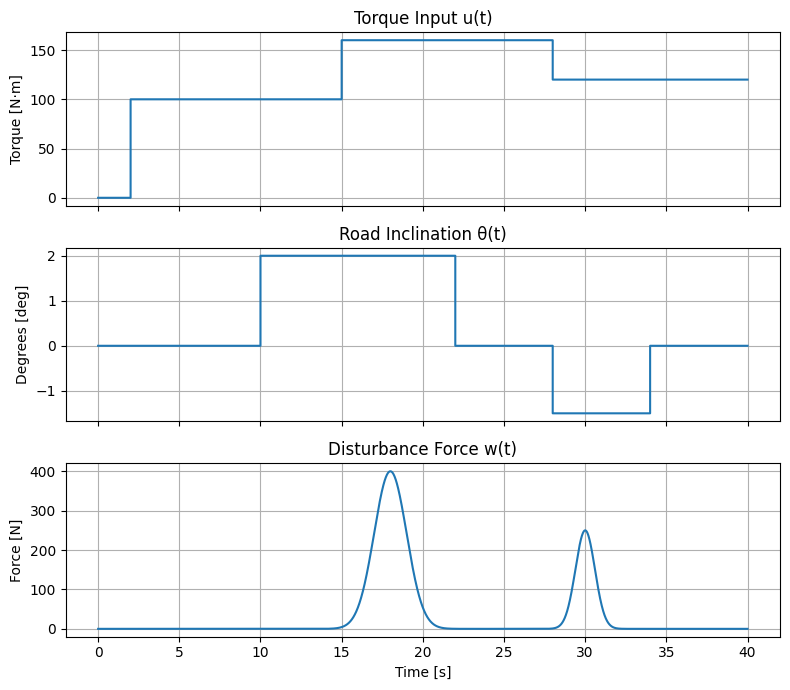

In [ ]:
# Define torque, slope, and disturbance profiles

def u_torque(t_scalar):
    """
    Torque profile [N·m]:
    - Step up to 100 N·m at 2 s
    - Add 60 N·m at 15 s
    - Reduce 40 N·m at 28 s
    """
    val = 0.0
    if t_scalar >= 2.0:  val += 100.0
    if t_scalar >= 15.0: val += 60.0
    if t_scalar >= 28.0: val -= 40.0
    return val

def theta_slope(t_scalar):
    """
    Road slope [radians]:
    - Uphill (+2°) from 10 s to 22 s
    - Downhill (-1.5°) from 28 s to 34 s
    """
    if 10.0 <= t_scalar < 22.0:
        return 2.0 * np.pi / 180.0
    if 28.0 <= t_scalar < 34.0:
        return -1.5 * np.pi / 180.0
    return 0.0

def w_disturbance(t_scalar):
    """
    External disturbance [N]:
    Two gusts of wind at 18 s and 30 s.
    """
    w1 = 400.0 * np.exp(-0.5 * ((t_scalar - 18.0)/1.0)**2)
    w2 = 250.0 * np.exp(-0.5 * ((t_scalar - 30.0)/0.6)**2)
    return w1 + w2

# Plot all three inputs

u = np.array([u_torque(ti) for ti in t])
th = np.array([theta_slope(ti) for ti in t])
w = np.array([w_disturbance(ti) for ti in t])

fig, ax = plt.subplots(3, 1, figsize=(8,7), sharex=True)

ax[0].step(t, u, where="post")
ax[0].set_title("Torque Input u(t)")
ax[0].set_ylabel("Torque [N·m]")
ax[0].grid(True)

ax[1].step(t, th * 180/np.pi, where="post")
ax[1].set_title("Road Inclination θ(t)")
ax[1].set_ylabel("Degrees [deg]")
ax[1].grid(True)

ax[2].plot(t, w)
ax[2].set_title("Disturbance Force w(t)")
ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Force [N]")
ax[2].grid(True)

plt.tight_layout()
plt.show()

Now our equation includes slope and disturbance:

$$
\dot v = -\frac{b}{m} v + \frac{k_u}{m} u - g \theta + \frac{1}{m} w
$$

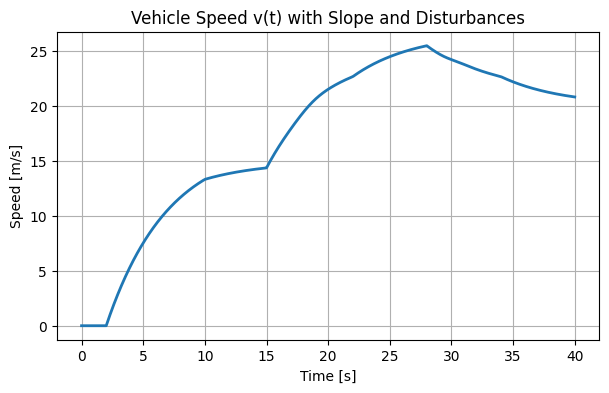

In [ ]:
# Vehicle dynamics with disturbances

def vehicle_dynamics_disturbance(v, u, theta, w, m, b, k_u, g):
    """
    Computes dv/dt for the full model with slope and disturbance.
    """
    return (-b/m)*v + (k_u/m)*u - g*theta + (1.0/m)*w

# Euler integration step

def euler_step_disturbance(v_k, u_k, theta_k, w_k, dt, m, b, k_u, g):
    dv = vehicle_dynamics_disturbance(v_k, u_k, theta_k, w_k, m, b, k_u, g)
    return v_k + dt * dv

# Simulation loop

def simulate_with_disturbance(t, v0, m, b, k_u, g, dt):
    v = np.zeros_like(t)
    v[0] = v0
    u_hist, th_hist, w_hist = np.zeros_like(t), np.zeros_like(t), np.zeros_like(t)
    for k in range(len(t)-1):
        u_hist[k]  = u_torque(t[k])
        th_hist[k] = theta_slope(t[k])
        w_hist[k]  = w_disturbance(t[k])
        v[k+1] = euler_step_disturbance(v[k], u_hist[k], th_hist[k], w_hist[k], dt, m, b, k_u, g)
    return v, u_hist, th_hist, w_hist

v, u, th, w = simulate_with_disturbance(t, v0=0.0, m=m, b=b, k_u=k_u, g=g, dt=dt)

# Plot the vehicle speed over time

plt.figure(figsize=(7,4))
plt.plot(t, v, linewidth=2)
plt.title("Vehicle Speed v(t) with Slope and Disturbances")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.grid(True)
plt.show()

* When the car goes uphill, gravity adds a negative term $-g\theta$, slowing the car.
* When the car goes downhill, gravity helps it accelerate.
* The wind disturbance $w(t)$ temporarily adds or removes force, changing the speed curve.
* Notice how, even without changing torque, the car's speed varies.

*This is why feedback control is needed!*

pg7-8 Mustafa

## Free Response and Stability

$\color{red}{TODO: Make the model consistent. Recall the model. Look into the case where u = 0, and callthis free response. Fix A, B everywhere.} \color{blue}{Mustafa:Done}$

Consider the system  
$$
\dot{x} = A x + B u, \quad x(0) = x_0, \quad u \equiv 0
$$

Then the free response is given by  
$$
x(t) = e^{A t} x_0
$$

$\color{red}{TODO: Let's look at 3 cases and we will look at how they behave there. Just don't mention stability yet. In the unstable case show the case where at zero it stays there and then also when the initial conditions diverge.} \color{blue}{Mustafa:Done}$

Let's look at three cases and check how the free response behaves:

---

#### 1. $A < 0$:
$$
e^{A t} x_0 \to 0 \quad \text{as } t \to \infty
$$  

$x(t)$ approaches to the stable point $0$ for all $x_0$.

---

#### 2. $A > 0$:
$$
|e^{A t} x_0| \text{ grows as } t \text{ increases} \text{ (assuming $x_0 \neq 0$)}
$$  

For $x_0 \neq 0$, $x(t)$ diverges to $-∞$ or $+∞$ depending on the sign of $x_{0}$.

For $x_0 = 0$, $x(t)$ remains at $0$.

---

#### 3. $A = 0$:
$$
x(t) = x_0 \text{ (constant over time)}
$$  

$x(t)$ remains at $x_0$ for all initial conditions $x_0$.


### **Stability Definitions**
---

#### 1. $A < 0$, **Asymptotically stable**:  
Free response converges to $0$ *for all* initial conditions.

---

#### 2. $A > 0$, **Unstable**:  

Free response diverges *for some* initial conditions.

---

#### 3. $A = 0$, **Marginally stable (or limitedly stable)**:  

Free response does not diverge for any initial condition. But, for some initial conditions it does not converge to $0$ either.

**Question:** Does stability depend on the initial condition or is it a property of the system?

$\color{red}{TODO: 3 different graphs for 3 cases, with different initial conditions to show stability/instability.} \color{blue}{Mustafa:Done}$

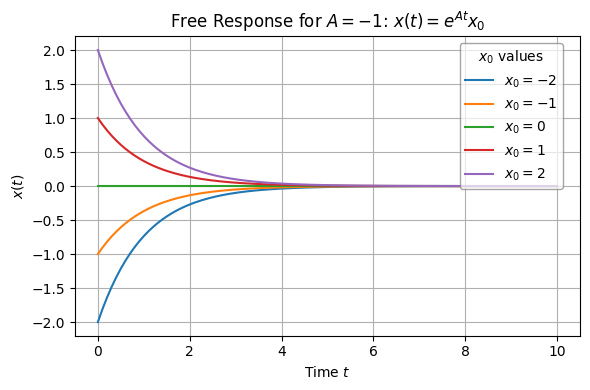

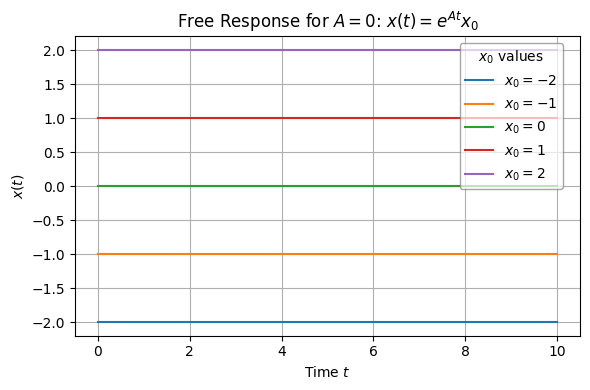

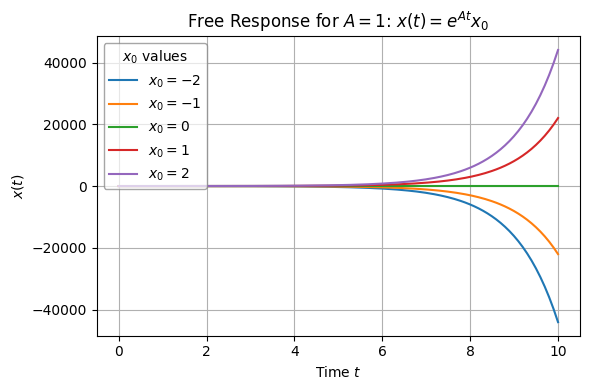

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x0_values = [-2, -1, 0, 1, 2]
t = np.linspace(0, 10, 200)
A_values = [-1, 0, 1]

# Generate plots
for A in A_values:
    plt.figure(figsize=(6, 4))
    for x0 in x0_values:
        x = np.exp(A * t) * x0
        plt.plot(t, x, label=f"$x_0 = {x0}$")

    plt.title(rf"Free Response for $A = {A}$: $x(t) = e^{{A t}} x_0$")
    plt.xlabel("Time $t$")
    plt.ylabel("$x(t)$")
    plt.grid(True)

    if A > 0:
    # Legend inside the plot at bottom-right
      plt.legend(
          title="$x_0$ values",
          loc="upper left",
          bbox_to_anchor=(0, 1.00),  # slightly inset from the edge
          ncol=1,
         frameon=True,
        facecolor="white",
        edgecolor="gray",
        framealpha=0.7   # transparency (0 = fully transparent, 1 = opaque)
      )
    else:
      plt.legend(
          title="$x_0$ values",
          loc="upper right",
          bbox_to_anchor=(0.98, 1.0),  # slightly inset from the edge
          ncol=1,
        frameon=True,
        facecolor="white",
        edgecolor="gray",
        framealpha=0.7   # transparency (0 = fully transparent, 1 = opaque)
      )

    plt.tight_layout()
    plt.show()


### Free Response and Time Constant

The solution of the system  
$$
x(t) = e^{A t} x_0
$$

Consider the case $A < 0$ (i.e., asymptotically stable).

At $t = 0$, the slope is  
$$
\dot{x}(0) = A x_0
$$

The **time constant** $T$ is defined as  
$$
T = \frac{1}{|A|} = -\frac{1}{A}, \quad \text{for } A < 0
$$

Hence,  
$$
x(t) = e^{A t} x_0 = e^{-t/T} x_0
$$

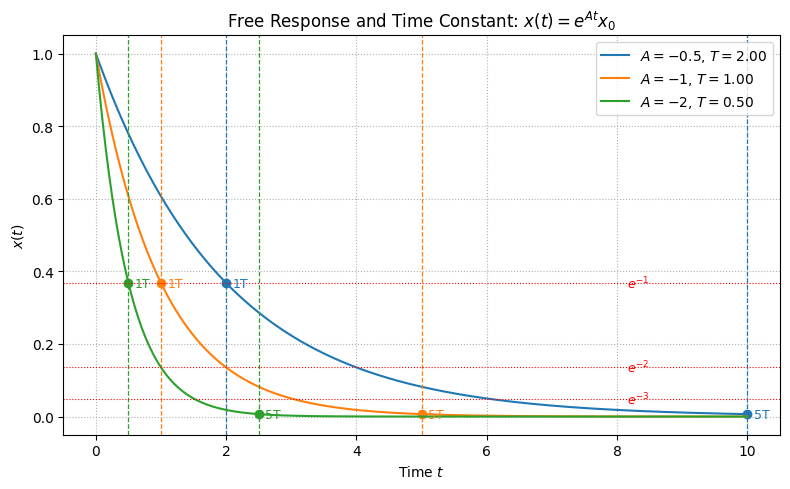

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x0 = 1.0
t = np.linspace(0, 10, 400)
A_values = [-0.5, -1, -2]  # asymptotically stable cases (a < 0)
colors = ['tab:blue', 'tab:orange', 'tab:green']  # consistent colors

plt.figure(figsize=(8, 5))

for A, color in zip(A_values, colors):
    T = -1 / A
    x = np.exp(A * t) * x0
    plt.plot(t, x, color=color, label=f"$A = {A}$, $T = {T:.2f}$")

    # Plot vertical dashed lines at 1T and 5T in same color
    for k, label_text in zip([1, 5], ['1T', '5T']):
        tT = k * T
        plt.axvline(tT, color=color, linestyle='--', linewidth=0.9)
        plt.plot(tT, np.exp(A * tT) * x0, 'o', color=color)
        plt.text(tT + 0.1, np.exp(A * tT) * x0, f"{label_text}",
                 color=color, va='center', fontsize=9)

# Add horizontal e^{-k} reference lines
for k in range(1, 4):
    plt.axhline(np.exp(-k), color='r', linestyle=':', linewidth=0.8)
    plt.text(8.15, np.exp(-k), f"$e^{{-{k}}}$", color='r', va='center', fontsize=9)

# Labels and formatting
plt.title(r"Free Response and Time Constant: $x(t) = e^{A t} x_0$")
plt.xlabel("Time $t$")
plt.ylabel("$x(t)$")
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()


## (Optional) Practical Uses of the Time Constant

The **time constant** $ T = \frac{1}{|a|} $ is a key concept in system dynamics, control, and signal processing. It describes how fast a system responds to changes or disturbances.

---

### ⚙️ 1. Understanding System Speed / Response Rate
- The time constant determines **how fast** a system responds to changes.  
- For a first-order system $ x(t) = e^{-t/T}x_0 $:
  - After $ 1T $: about 37% of the initial value remains  
  - After $ 3T $: about 5% remains  
  - After $ 5T $: about 1% remains  
- Therefore, the system is considered **settled** after roughly **five time constants**.

---

### 🔧 2. Mechanical and Aerospace Systems
- For a **mass-damper system**,  
  $$
  m \ddot{x} + b \dot{x} = 0
  $$
  the velocity response follows  
  $$
  \dot{x}(t) = \dot{x}_0 e^{-t/T}
  $$
  where  
  $$
  T = \frac{m}{b}.
  $$
- **Interpretation:**  
  The larger the mass (inertia), the slower the system responds. The greater the damping coefficient $b$, the faster the system settles.  
- **Example – Aerospace Application:**  
  Consider a small unmanned aerial vehicle (UAV) performing altitude control.  
  - The **mass** represents the vehicle’s inertia resisting acceleration.  
  - The **damping** (from drag or control feedback) dissipates energy and smooths motion.  
  - The time constant $ T = \frac{m}{b} $ tells how quickly altitude or pitch rate stabilizes after a thrust or control input.  
  In practice, flight control systems use the time constant to ensure that roll, pitch, and yaw responses settle within acceptable time limits for maneuverability and comfort.

---

### ⚡ 3. Electrical Circuits
- **Resistor-Capacitor Circuit:** $ T = RC $
  - Describes how quickly a capacitor charges or discharges.  
  - After $ 5RC $, the capacitor is ~99% charged or discharged.
- **Resistor-Inductor Circuit:** $ T = \frac{L}{R} $
  - Determines how fast current builds up through an inductor.
- In circuit design, engineers use the time constant to shape **filter bandwidths**, **delay responses**, and **switching speeds**.

---

### 🎛️ 4. Control Systems
- The time constant defines **transient response** characteristics.
- Systems with several time constants can often be approximated by their **dominant** one.
- Used for controller design and performance metrics such as rise time and settling time:
  $$
  t_{\text{settling}} \approx 5T
  $$
  (We will learn about these concepts in later lectures.)
- In aerospace control (e.g., autopilots), desired time constants are often specified for roll or pitch dynamics to ensure responsive but stable flight.

---

### 📡 5. Signal Processing and Filters
- For a first-order **low-pass filter**, $ T = \frac{1}{2\pi f_c} $, where $ f_c $ is the cutoff frequency.
- Determines how quickly high-frequency components are attenuated:
  - Small $T$ → fast response, wide bandwidth.  
  - Large $T$ → slow response, smoother output.
- Used in avionics sensors to remove noise from accelerometers or gyroscopes while maintaining fast reaction times.

---

### 🧠 6. Biological and Economic Models
- **Neurons:** Membrane time constant $ T_m = R_m C_m $ defines how fast voltage changes.  
- **Economics:** Time constants describe adaptation rates or adjustment speeds in dynamic models.

---

In summary, the **time constant** provides a universal measure of how quickly a system reacts and settles — whether it’s a **mechanical aircraft response**, an **electrical circuit**, or a **thermal or biological system**.  
In aerospace, engineers often design controllers to achieve **desired time constants** that balance **stability**, **responsiveness**, and **passenger comfort**.


## Forced Response

### 🌱 What is the forced response?

$\color{red}{TODO: Language and notation needs to be consistent. Consistency. Consistency.}$

$\color{blue}{Done}$

For a **linear time-invariant (LTI)** system:
$$
\frac{dx(t)}{dt} = a\,x(t) + b\,u(t)
$$

the total response can be split into two components:
$$
x(t) = x_{\text{free}}(t) + x_{\text{forced}}(t)
$$

| Part | Caused by | Exists if input = 0? | Depends on IC? | Behavior (for stable systems) |
|------|------------|----------------------|----------------|-------------------------------|
| **Free response** | The system’s own dynamics | ✅ Yes | ✅ Yes | Decays over time (transient) |
| **Forced response** | The external input | ❌ No | ❌ No | Persists as long as input acts |

* The **free response** represents how the system's stored energy (initial state) decays.  
* The **forced response** represents how the system reacts to external forcing (input).

Example intuition:  
If you push a mass-spring-damper system, its oscillation after you stop pushing is the *free response*,  
while its steady deformation under a constant force is the *forced response*.


### We now consider the *forced response* of a first-order system subjected to a **step input**.

Consider the system
$$
\frac{dx(t)}{dt} = a\,x(t) + b\,u(t), \qquad x(0)=x_0
$$

and the **step input**

$$
u(t) =
\begin{cases}
0, & t<0,\\[3pt]
u_m, & t\ge 0.
\end{cases}
$$

This is known as a **step input** of magnitude $u_m$.


$\color{red}{TODO: Side-by-side curves for the inputs and corresponding outputs for several different gains.}$

$\color{blue}{Done}$

The total solution is obtained from the variation-of-constants formula:
$$
x(t) = e^{a t}x_0 + \int_{0}^{t} e^{a(t-\tau)} b\,u(\tau)\, d\tau .
$$

For a step input ($u(\tau)=u_m$ for $\tau\ge0$):
$$
\begin{aligned}
x(t)
&= e^{a t}x_0 + b\,u_m\, e^{a t} \int_{0}^{t} e^{-a\tau}\, d\tau \\
&= e^{a t}x_0 + b\,u_m\, e^{a t}\,\frac{1 - e^{-a t}}{a} \\[2mm]
&= e^{a t}x_0 + \frac{b\,u_m}{a}\,(e^{a t} - 1)
\end{aligned}
$$

For a **zero initial condition** ($x_0 = 0$), the first term vanishes, leaving only the **forced response**:
$$
x(t) = -\frac{b}{a}u_m\,(1 - e^{a t})
$$

---

#### 📈 Interpretation

* For $a < 0$, the exponential term $e^{a t}$ decays to zero → the system is **stable**.  
* The steady-state value (as $t \to \infty$) is:
  $$
  x_{ss} = -\frac{b}{a}\,u_m
  $$
* The **DC gain** is the ratio of steady-state output to steady-state input:
  $$
  \frac{x_{ss}}{u_m} = -\frac{b}{a}.
  $$

The response approaches its steady-state exponentially:
$$
x(t) = x_{ss}\,\big(1 - e^{a t}\big)
$$
Recall the **time constant** is
$$
\tau = \frac{1}{|a|}.
$$

At $t = \tau$, the output reaches about **63.2%** of its final value:
$$
x(\tau) = x_{ss}\,(1 - e^{-1}) \approx 0.632\,x_{ss}.
$$

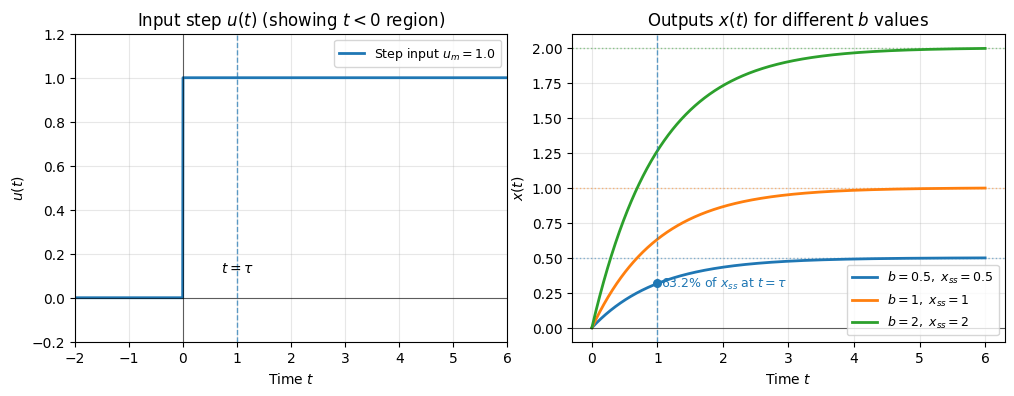

In [7]:
# Corrected version: consistent legend and color mapping for b values

import numpy as np
import matplotlib.pyplot as plt

def plot_inputs_outputs_multi_b(a=-1.0, b_values=(0.5, 1.0, 2.0),
                                u_m=1.0, t_pre=2.0, t_end=8.0, n_pts=1200):
    """
    Consistent notation: x(t) = -(b/a) * u_m * (1 - e^{a t})
    Shows input step (t<0 region) and responses for several b values.
    """
    if a >= 0:
        raise ValueError("Use a < 0 for a stable first-order system.")
    b_values = list(b_values)
    if len(b_values) == 0:
        raise ValueError("Provide at least one value in b_values.")

    # Time setup
    t_full = np.linspace(-t_pre, t_end, n_pts)
    t = np.linspace(0.0, t_end, n_pts)
    u = np.where(t_full >= 0, u_m, 0.0)
    tau = 1.0 / abs(a)

    # --- Figure setup ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False, gridspec_kw=dict(wspace=0.15))
    ax_u, ax_x = axes

    # --- Left: Step input ---
    ax_u.plot(t_full, u, linewidth=2, color='tab:blue', label=f"Step input $u_m={u_m}$")
    ax_u.axhline(0, color='k', linewidth=0.8, alpha=0.6)
    ax_u.axvline(0, color='k', linewidth=0.8, alpha=0.6)
    ax_u.axvline(tau, linestyle='--', linewidth=1, alpha=0.7)
    ax_u.text(tau, u_m*0.1, r"$t=\tau$", ha="center", va="bottom")
    ax_u.set_xlim(-t_pre, t_end)
    ax_u.set_ylim(-0.2*u_m, 1.2*u_m)
    ax_u.set_title("Input step $u(t)$ (showing $t<0$ region)")
    ax_u.set_xlabel("Time $t$")
    ax_u.set_ylabel("$u(t)$")
    ax_u.grid(True, alpha=0.3)
    ax_u.legend(fontsize=9)

    # --- Right: Outputs x(t) for multiple b values ---
    cmap = plt.get_cmap('tab10')
    legends = []

    for i, b in enumerate(b_values):
        color = cmap(i % 10)
        x_ss = -(b/a) * u_m
        x = x_ss * (1.0 - np.exp(a * t))
        ax_x.plot(t, x, linewidth=2, color=color, label=fr"$b={b:g},\ x_{{ss}}={x_ss:g}$")
        ax_x.axhline(x_ss, linestyle=':', linewidth=1, color=color, alpha=0.5)

    # 63.2% marker for first curve
    b0 = b_values[0]
    xss0 = -(b0/a) * u_m
    ax_x.scatter([tau], [xss0*(1 - np.e**-1)], s=30, zorder=5, color=cmap(0))
    ax_x.annotate(r"$63.2\%$ of $x_{ss}$ at $t=\tau$",
                  xy=(tau, xss0*(1 - np.e**-1)),
                  xytext=(tau*1.05, xss0*(1 - np.e**-1)),
                  ha="left", va="center", fontsize=9, color=cmap(0))

    # axis formatting
    ax_x.axhline(0, color='k', linewidth=0.8, alpha=0.6)
    ax_x.axvline(tau, linestyle='--', linewidth=1, alpha=0.7)
    ax_x.set_title("Outputs $x(t)$ for different $b$ values")
    ax_x.set_xlabel("Time $t$")
    ax_x.set_ylabel("$x(t)$")
    ax_x.grid(True, alpha=0.3)
    ax_x.legend(fontsize=9)

    plt.show()

# Example run
plot_inputs_outputs_multi_b(a=-1.0, b_values=(0.5, 1.0, 2.0), u_m=1.0, t_pre=2.0, t_end=6.0)

### Forced Response Simulation for Different Initial Conditions

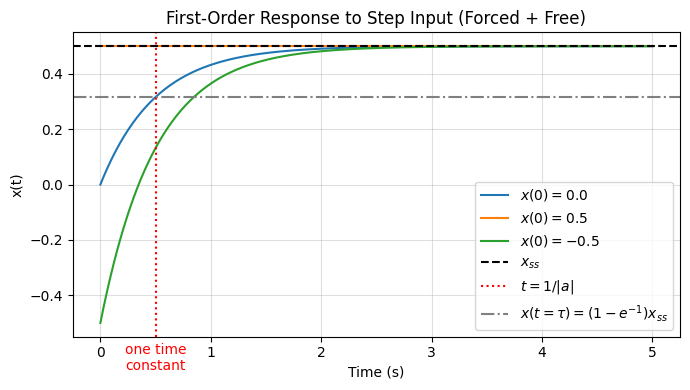

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- System Parameters ---
a = -2.0      # system coefficient (a < 0 for stability)
b = 1.0       # input coefficient
um = 1.0      # step magnitude
t = np.linspace(0, 5, 500)

# --- Response function ---
def response(a, b, um, x0, t):
    """Total response = free + forced."""
    x_forced = -b/a * um * (1 - np.exp(a*t))
    x_free = x0 * np.exp(a*t)
    return x_forced + x_free

# --- Simulate for several initial conditions ---
x0_values = [0.0, 0.5, -0.5]
plt.figure(figsize=(7, 4))
for x0 in x0_values:
    plt.plot(t, response(a, b, um, x0, t), label=f"$x(0)={x0}$")

# --- Compute key quantities ---
xss = -b/a * um                # steady-state value
tau = 1/abs(a)                 # time constant
x_tau = (1 - np.exp(-1)) * xss # value at one time constant (e^-1 * xss above zero IC)

# --- Plot steady-state and time-constant markers ---
plt.axhline(xss, color='k', linestyle='--', label=r"$x_{ss}$")
plt.axvline(tau, color='r', linestyle=':', label=r"$t = 1/|a|$")
plt.axhline(x_tau, color='gray', linestyle='-.', label=r"$x(t=\tau) = (1-e^{-1})x_{ss}$")

# --- Label "one time constant" on x-axis ---
plt.text(tau, plt.ylim()[0] + -0.12*(plt.ylim()[1]-plt.ylim()[0]),
         "one time\nconstant", color='r', ha='center', va='bottom', rotation=0)

# --- Formatting ---
plt.xlabel("Time (s)")
plt.ylabel("x(t)")
plt.title("First-Order Response to Step Input (Forced + Free)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

## Complete Solution for Step Input

For a first-order linear system,
$$
\dot{x}(t) = a\,x(t) + b\,u(t), \qquad x(0) = x_0,
$$
the complete solution combines two parts:
$$
\text{Complete solution} =
\underbrace{\text{Free response}}_{\text{Solution for } u(t)\equiv0}
+
\underbrace{\text{Forced response}}_{\text{Solution for } x_0=0}.
$$

---

### Analytical Expression
Given the concept above, the general solution of a first-order linear system under a step input is
$$
x(t) = x_f(t) + x_{fs}(t),
$$
where, per the previous derivations:
- **Free response:** $x_f(t) = x_0\,e^{a t}$
- **Forced response:** $x_{fs}(t) = -\dfrac{b}{a}\,u_m\,(1 - e^{a t})$
Thus,
$$
x(t) = x_0\,e^{a t} - \frac{b}{a}\,u_m\,(1 - e^{a t}).
$$
---

### Example
Let
$$
a < 0,\quad x_0 = 1,\quad -\frac{b}{a}\,u_m = 2.
$$
Then the total response is
$$
x(t) = e^{a t} + 2(1 -  e^{a t}) = 2 - e^{a t}.
$$

---
### Visualization
- The free response starts at $1$ and decays to $0$.  
- The forced response starts at $0$ and rises to $2$.  
- The complete solution starts at $1$ and asymptotically approaches $2$.




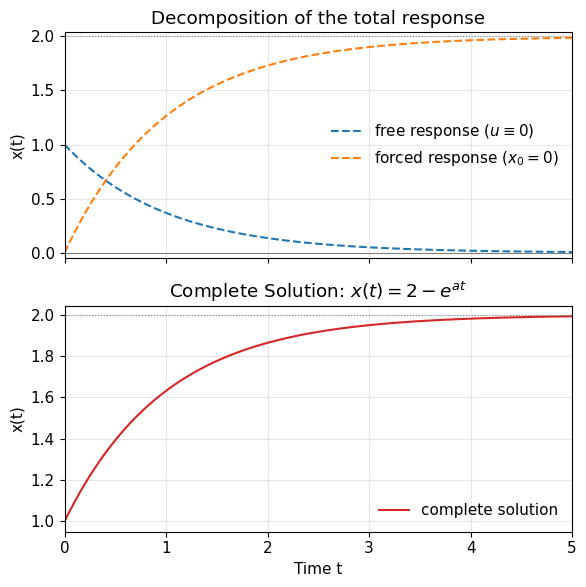

In [ ]:
plt.rcParams.update({
    "mathtext.fontset": "dejavusans",
    "font.family": "DejaVu Sans",
    "font.size": 11
})
# ---- Parameters ----
a = -1.0           # stable system (a < 0)
b = 1.0
x0 = 1.0
u_m = 2.0          # chosen so that -(b/a)*u_m = 2
# ---- Time and analytic responses ----
t = np.linspace(0, 5, 400)
x_free   = x0 * np.exp(a*t)
x_forced = -(b/a)*u_m*(1 - np.exp(a*t))
x_total  = x_free + x_forced
# ---- Two stacked subplots ----
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)
# (1) Free + Forced components
ax[0].plot(t, x_free, '--', label='free response ($u\\equiv0$)')
ax[0].plot(t, x_forced, '--', label='forced response ($x_0=0$)')
ax[0].axhline(0, color='gray', lw=0.8)
ax[0].axhline(2, color='gray', ls=':', lw=0.8)
ax[0].set_ylabel("x(t)")
ax[0].set_title("Decomposition of the total response")
ax[0].legend(frameon=False)
ax[0].grid(alpha=0.3)
ax[0].set_xlim(t[0], t[-1])
ax[0].set_ylim(min(x_free.min(), x_forced.min()) - 0.05,
               max(x_free.max(), x_forced.max()) + 0.05)
# (2) Complete solution
ax[1].plot(t, x_total, color='C3', label='complete solution')
ax[1].axhline(2, color='gray', ls=':', lw=0.8)
ax[1].set_xlabel("Time t")
ax[1].set_ylabel("x(t)")
ax[1].set_title("Complete Solution: $x(t) = 2 - e^{a t}$")
ax[1].legend(frameon=False)
ax[1].grid(alpha=0.3)
ax[1].set_xlim(t[0], t[-1])
ax[1].set_ylim(x_total.min() - 0.05, x_total.max() + 0.05)
plt.tight_layout()
plt.show()
